<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/lvm/vae_mnist_2d_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder for MNIST

We fit a convolutional VAE  using code borrowed from
 https://www.tensorflow.org/beta/tutorials/generative/cvae. 
 
Then we analyze the 2d latent space using code borrowed from
 https://github.com/davidADSP/GDL_code/blob/master/03_04_vae_digits_analysis.ipynb
 

## Import TensorFlow and other libraries

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

## Load the dataset


In [0]:
dataname = 'mnist' 
from tensorflow import keras


(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
#train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
train_images = train_images / 255 # Normalize the images to [0,1]
#train_images = (train_images * 2) -1 # Normalize the images to [-1, 1]

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


print(train_images.shape)
input_shape = train_images.shape[1:]



# Model

In [0]:
class ConvVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=input_shape),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
   ]
    )

    nrows = input_shape[0]
    ncols = input_shape[1]
    nrows_latent = int(nrows/4) # we upsample by 4 using 2 layers of Conv' with stride 2
    ncols_latent = int(ncols/4)
    num_colors = input_shape[2]
    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=nrows_latent*ncols_latent*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(nrows_latent, ncols_latent, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=num_colors, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      nsamples  = 1
      eps = tf.random.normal(shape=(nsamples, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-3)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training



In [0]:
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = ConvVAE(latent_dim)

In [0]:
num_colors = input_shape[2]
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      if num_colors == 1:
         plt.imshow(predictions[i, :, :, 0], cmap='gray')
      else:
         plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.title('epoch {}'.format(epoch))
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
  
  
generate_and_save_images(model, 0, random_vector_for_generation)  

In [0]:
test_input=random_vector_for_generation
predictions = model.sample(test_input)
print(test_input.shape)
print(predictions.shape)


In [0]:
epoch_start = 1 # change this to warm start from earlier run
epochs = 5

for epoch in range(epoch_start+1, epoch_start + epochs):
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  generate_and_save_images(
        model, epoch, random_vector_for_generation)

## Analyze model

https://github.com/davidADSP/GDL_code/blob/master/03_04_vae_digits_analysis.ipynb

In [0]:
# Make some wrapper functions

def vae_encode(model, x):
  mean, logvar = model.encode(x)
  z_points = model.reparameterize(mean, logvar)
  return z_points

def vae_decode(model, z_points):
  x_logit = model.decode(z_points)
  reconst_images = tf.math.sigmoid(x_logit)
  return reconst_images

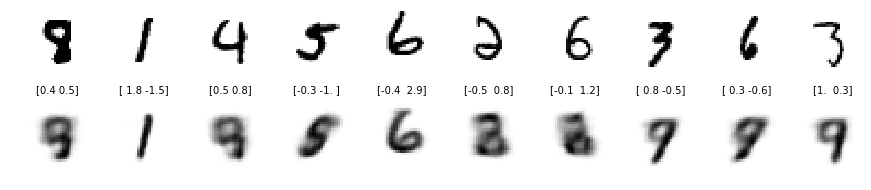

In [24]:
n_to_show = 10
n_train = train_images.shape[0]
example_idx = np.random.choice(range(n_train), n_to_show)
example_images = train_images[example_idx,:,:,:]


# GDL code
#z_points = vae.encoder.predict(example_images)
#reconst_images = vae.decoder.predict(z_points)

z_points = vae_encode(model, example_images)
reconst_images = vae_decode(model, z_points)


fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    #img = example_images[i].squeeze()
    img = example_images[i,:,:,0]
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)         
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    #img = reconst_images[i].squeeze()
    img = reconst_images[i,:,:,0]
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')

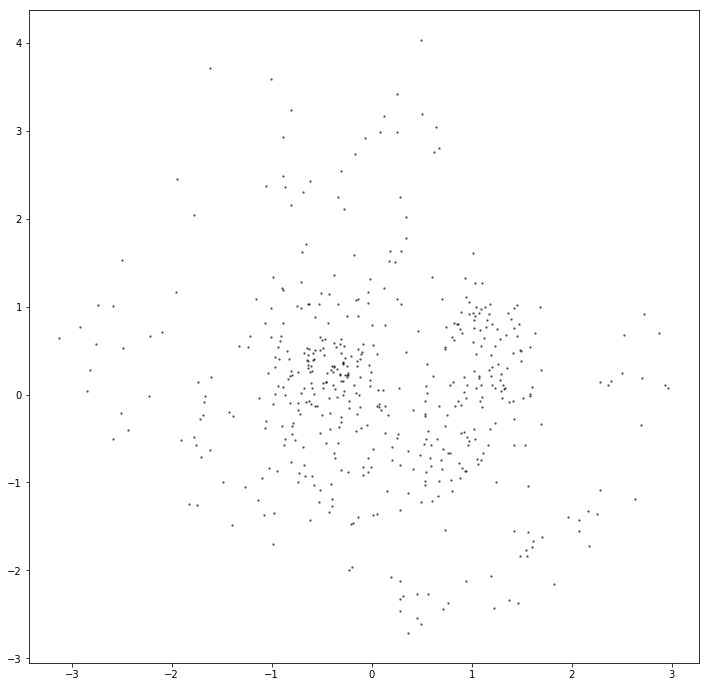

In [25]:
n_to_show = 500
figsize = 12

#example_idx = np.random.choice(range(len(x_test)), n_to_show)
#example_images = x_test[example_idx]
#example_labels = y_test[example_idx]
#z_points = vae.encoder.predict(example_images)

n_train = train_images.shape[0]
example_idx = np.random.choice(range(n_train), n_to_show)
example_images = train_images[example_idx,:,:,:]
example_labels = train_labels[example_idx]

z_points = vae_encode(model, example_images)


min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



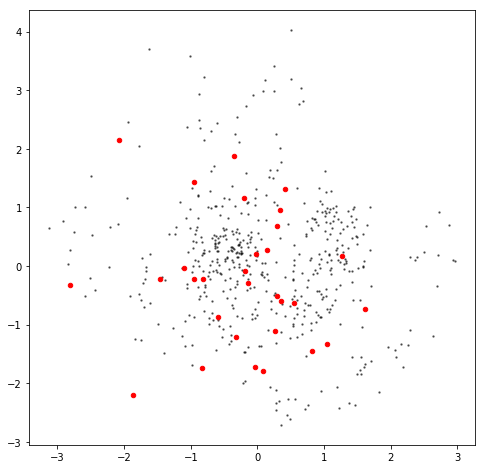

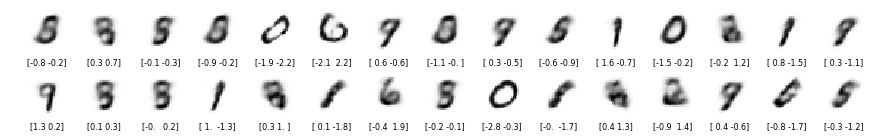

In [26]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
#reconst = vae.decoder.predict(z_grid)

reconst = vae_decode(model, z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
    

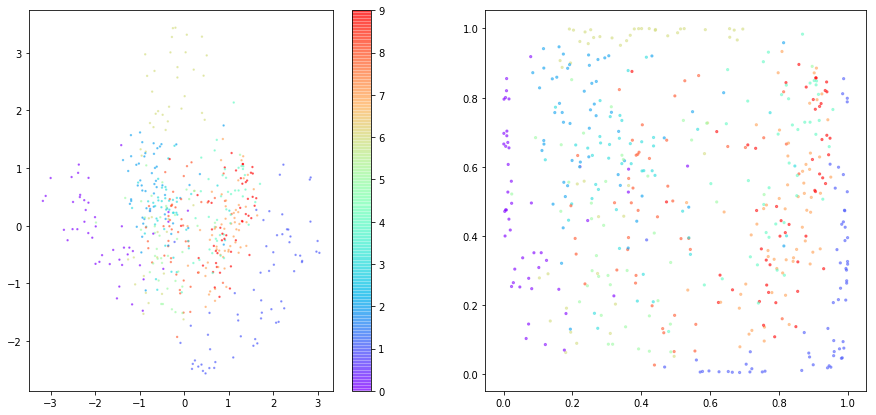

In [29]:
from scipy.stats import norm

n_to_show = 500
grid_size = 15
fig_height = 7
fig_width = 15

#example_idx = np.random.choice(range(len(x_test)), n_to_show)
#example_images = x_test[example_idx]
#example_labels = y_test[example_idx]

n_train = train_images.shape[0]
example_idx = np.random.choice(range(n_train), n_to_show)
example_images = train_images[example_idx,:,:,:]
example_labels = train_labels[example_idx]


#z_points = vae.encoder.predict(example_images)
z_points = vae_encode(model, example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

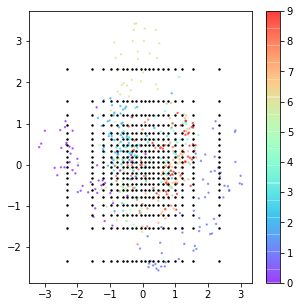

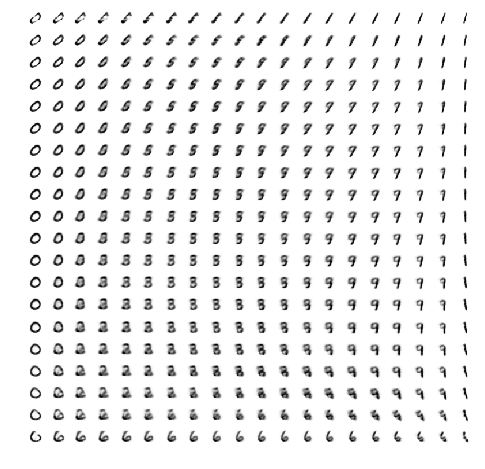

In [30]:
n_to_show = 500
grid_size = 20
figsize = 8

#example_idx = np.random.choice(range(len(x_test)), n_to_show)
#example_images = x_test[example_idx]
#example_labels = y_test[example_idx]

#z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

#reconst = vae.decoder.predict(z_grid)
reconst = vae_decode(model, z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)

plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')
plt.show()